In [2]:
# Julia version of the code for Chapter 5.2 in Herbst and Schorfheide (2015)
# Author: Takeki Sunakawa
# Mail: takeki.sunakawa@gmail.com
# Last updated: April 19, 2019 @ Cafe de Crie, Kobe Motomachi

using DelimitedFiles
using Random
using ControlSystems # not in CoCalc
using Distributions # not in CoCalc
using PDMats # not in CoCalc
using StatsBase # not in CoCalc
using Plots
using KernelDensity
include("gensys.jl")

new_div (generic function with 1 method)

In [20]:
function model_solution(para)

# Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]
    sigma_g = para[12]
    sigma_z = para[13]
    bet = 1/(1+rA/400)

    # Equation indices

    eq_1   = 1  #** (2.1) on \hat{y}(t) **/
    eq_2   = 2  #** (2.1) on \hat{pi}(t) **/
    eq_3   = 3  #** (2.1) on \hat{R}(t) **/
    eq_4   = 4  #** \hat{y}(t-1) **/
    eq_5   = 5  #** \hat{g} process **/
    eq_6   = 6  #** \hat{z} process **/
    eq_7   = 7  #** \hat{y} expectational error **/
    eq_8   = 8  #** \hat{pi} expectational error **/

    # Variable indices 

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # Expectation error indices (eta) 

    ey_sh  = 1
    epi_sh = 2       

    # Shock indices (eps)

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # SUMMARY

    neq  = 8
    neta = 2
    neps = 3

    # /** initialize matrices **/

    GAM0 = zeros(neq,neq)
    GAM1 = zeros(neq,neq)
       C = zeros(neq,1)        
     PSI = zeros(neq,neps)
     PPI = zeros(neq,neta)


    # =========================================================================
    #                 EQUILIBRIUM CONDITIONS: CANONICAL SYSTEM
    # =========================================================================

    # =========================================================================
    #          1. 
    # =========================================================================

    GAM0[eq_1,y_t] =  1
    GAM0[eq_1,R_t] =  1/tau
    GAM0[eq_1,g_t] = -(1-rho_g)
    GAM0[eq_1,z_t] = -rho_z/tau
    GAM0[eq_1,Ey_t1] = -1
    GAM0[eq_1,Epi_t1] = -1/tau

    # =========================================================================
    #          2. 
    # =========================================================================

    GAM0[eq_2,y_t] = -kappa;
    GAM0[eq_2,pi_t] = 1;
    GAM0[eq_2,g_t] =  kappa;
    GAM0[eq_2,Epi_t1] = -bet;

    # =========================================================================
    #          3. 
    # =========================================================================

    GAM0[eq_3,y_t] = -(1-rho_R)*psi2
    GAM0[eq_3,pi_t] = -(1-rho_R)*psi1
    GAM0[eq_3,R_t] = 1
    GAM0[eq_3,g_t] = (1-rho_R)*psi2
    GAM1[eq_3,R_t] = rho_R
    PSI[eq_3,R_sh] = 1

    # =========================================================================
    #          4. 
    # =========================================================================

    GAM0[eq_4,y1_t] = 1
    GAM1[eq_4,y_t] = 1

    # =========================================================================
    #          5. 
    # =========================================================================

    GAM0[eq_5,g_t] = 1
    GAM1[eq_5,g_t] = rho_g
    PSI[eq_5,g_sh] = 1

    # =========================================================================
    #          6. 
    # =========================================================================

    GAM0[eq_6,z_t] = 1
    GAM1[eq_6,z_t] = rho_z
    PSI[eq_6,z_sh] = 1

    # =========================================================================
    #          7. 
    # =========================================================================

    GAM0[eq_7,y_t] = 1
    GAM1[eq_7,Ey_t1] = 1
    PPI[eq_7,ey_sh] = 1

    # =========================================================================
    #          8. 
    # =========================================================================

    GAM0[eq_8,pi_t] = 1
    GAM1[eq_8,Epi_t1] = 1
    PPI[eq_8,epi_sh] = 1


    # =========================================================================
    #            QZ(generalized Schur) decomposition by GENSYS
    # =========================================================================

    T1, TC, T0, fmat, fwt, ywt, gev, eu, loose = gensys(GAM0,GAM1,C,PSI,PPI)

    return T1, T0

end

model_solution (generic function with 1 method)

In [21]:
function sysmat(T1,T0,para)

# Theta = [tau kappa psi1 psi2 rA piA gammaQ rho_R rho_g rho_z sigma_R sigma_g sigma_z]
    tau     = para[1]
    kappa   = para[2]
    psi1    = para[3]
    psi2    = para[4]
    rA      = para[5]
    piA     = para[6]
    gammaQ  = para[7]
    rho_R   = para[8]
    rho_g   = para[9]
    rho_z   = para[10]
    sigma_R = para[11]
    sigma_g = para[12]
    sigma_z = para[13]
    
    eq_y = 1
    eq_pi = 2
    eq_ffr = 3

    # /** number of observation variables **/

    ny = 3

    # /** model variable indices **/

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # /** shock indices **/

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # =========================================================================
    #                           TRANSITION EQUATION
    #    
    #            s(t) = Phi*s(t-1) + R*e(t)
    #            e(t) ~ iid N(0,Se)
    #  
    # =========================================================================

    nep = size(T0,2)

    Phi = T1

    R   = T0

    Se  = zeros(nep,nep)

    Se[z_sh,z_sh] = (sigma_z)^2
    Se[g_sh,g_sh] = (sigma_g)^2
    Se[R_sh,R_sh] = (sigma_R)^2

    # =========================================================================
    #                           MEASUREMENT EQUATION
    #   
    #            y(t) = a + b*s(t) + u(t) 
    #            u(t) ~ N(0,HH)
    #  
    # =========================================================================

    A           = zeros(ny,1)
    A[eq_y,1]   = gammaQ
    A[eq_pi,1]  = piA
    A[eq_ffr,1] = piA+rA+4*gammaQ

    nstate = size(Phi,2)

    B = zeros(ny,nstate)

    B[eq_y,y_t]   = 1
    B[eq_y,y1_t]  = -1 
    B[eq_y, z_t]  = 1
    B[eq_pi,pi_t] = 4
    B[eq_ffr,R_t] = 4

    H = zeros(ny,ny)
    # with measurement errors (from dsge1_me.yaml)
    H[eq_y,y_t] = (0.20*0.579923)^2
    H[eq_pi,pi_t] = (0.20*1.470832)^2
    H[eq_ffr,R_t] = (0.20*2.237937)^2
    
    return A,B,H,R,Se,Phi

end

sysmat (generic function with 1 method)

In [22]:
function nearestSPD(A)

    # symmetrize A into B
    B = (A + A')/2

    # Compute the symmetric polar factor of B. Call it H.
    # Clearly H is itself SPD.
    U,Sigma,V = svd(B)
    H = V*diagm(0=>Sigma)*V'

    # get Ahat in the above formula
    Ahat = (B+H)/2

    # ensure symmetry
    Ahat = (Ahat + Ahat')/2

    p = 1
    k = 0

    while (p != 0) 
        p = 0
        try
            R = cholesky(Ahat)
        catch
            p = 1
        end    

        if (p != 0)
            k = k + 1
            mineig = -maximum(-eigvals(Ahat))
            Ahat = Ahat + (-mineig*k^2 + eps(mineig))*Matrix(1.0I,size(A,1),size(A,1))
        end

    end

    return Ahat
end

nearestSPD (generic function with 1 method)

In [23]:
function PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, resample)

    # housekeeping
    ne        = size(S2,1)
    ns = size(B,2)
    T         = size(yt,1)
    temp = cholesky(S2)
    sqrtS2 = R*temp.U'

    # matrix for store
    all_s_up  = zeros(T,ns,N) # resampled
    lik       = zeros(T,1)
    Neff      = zeros(T,1)

    # initialization
    temp_s = x0
    temp_P = P0
    temp = cholesky(temp_P)
    s_up = repeat(temp_s,1,N) + temp.U'*randn(ns,N)

    weights = ones(N,1)

    yy = zeros(3,1)

    # Rest of Steps
    for tt=1:1:T

        yy[:,1] = yt[tt,:]'

        # Propagate
        s_fore = Phi*s_up + sqrtS2*randn(ne,N)

        # Un-normalized weights (naive boostrap particle filter)
        perror = repeat(yy-A,1,N) - B*s_fore
        d = MvNormal(PDMat(H))
        density = pdf(d,perror)

        # Store results
        lik[tt,1]        = log(mean(density.*weights))
        all_s_up[tt,:,:] = s_up

        # Normalize weights
        weights = (density.*weights)./(mean(density.*weights))

        # Effective sample size
        Neff[tt,1] = (N^2)/sum(weights.^2)

        if resample == 1 && Neff[tt,1] <= N/2
            s_up = s_fore[:,sample(collect(1:N),Weights(weights[:,1]),N,replace=true)] # Resampling if ESS falls below a threshold
            weights = ones(N,1)
        else
            s_up = s_fore
        end    

    end

    return lik, all_s_up, Neff
end

PF_lik (generic function with 1 method)

In [24]:
function KF(A,B,H,R,Se,Phi,y)
    
    # Initialize the State Vector at the Stationary Distribution
    T,l    = size(y)
    n,n    = size(Phi)
    s        = zeros(T+1,n)
    P        = zeros(T+1,n,n)
    s[1,:]   = zeros(n,1)'

    a = inv(Matrix(1.0I,n*n,n*n) - kron(Phi,Phi))*reshape(R*Se*R',n*n,1)
    P[1,:,:] = reshape(a,n,n)

    # Kalman Filter Recursion
    sprime             = zeros(n,1)
    Pprime             = zeros(n,n)
    errorprediction    = ones(T,l)
    Varerrorprediction = ones(T,l,l)
    liki               = ones(T,1)
    measurepredi       = ones(T,l)

    for i=1:T

        # Updating Step

        sprime = Phi*s[i,:]
        Pprime = Phi*P[i,:,:]*Phi' + R*Se*R'

        # Prediction Step

        yprediction = A + B*sprime

        v = y[i,:] - yprediction

        F = B*Pprime*B' + H

        kgain    = Pprime*B'*inv(F)
        s[i+1,:] = (sprime + kgain*v)'
        P[i+1,:,:] = Pprime - kgain*B*Pprime
        errorprediction[i,:] = v'
        Varerrorprediction[i,:,:] = F
        temp = 0.5*v'*inv(F)*v
        liki[i] = -0.5*l*log(2*pi) - 0.5*log(det(F)) - temp[1]
        measurepredi[i,:] = y[i,:]-v
    
    end


    statepredi = s
    varstatepredi = P

    return liki,measurepredi,statepredi,varstatepredi
end

KF (generic function with 1 method)

In [26]:
# main
yt = readdlm("us.txt")
# m = Model(2.09,0.98,2.25,0.65,0.34,3.16,0.51,0.81,0.98,0.93,0.19,0.65,0.24)
para = [2.09,0.98,2.25,0.65,0.34,3.16,0.51,0.81,0.98,0.93,0.19,0.65,0.24]
T1,T0 = model_solution(para)
A,B,H,R,S2,Phi = sysmat(T1,T0,para)

@time liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt);

  0.111401 seconds (190.22 k allocations: 10.311 MiB, 8.74% gc time)


In [39]:
rng = MersenneTwister(1234)

ns = size(B,2)
x0 = zeros(ns)
P0 = nearestSPD(dlyap(Phi,R*S2*R')) # to make it positive semidefinite

N = 40000 # number of particles 
@time lik, all_s_up, Neff = PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, 1);

  1.289149 seconds (517.75 k allocations: 1.710 GiB, 24.16% gc time)


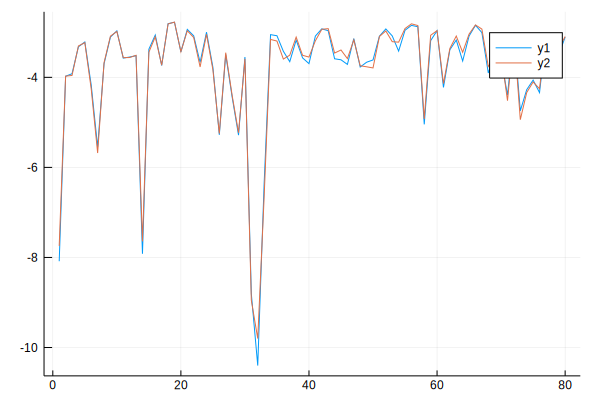

In [40]:
plot(liki)
plot!(lik)

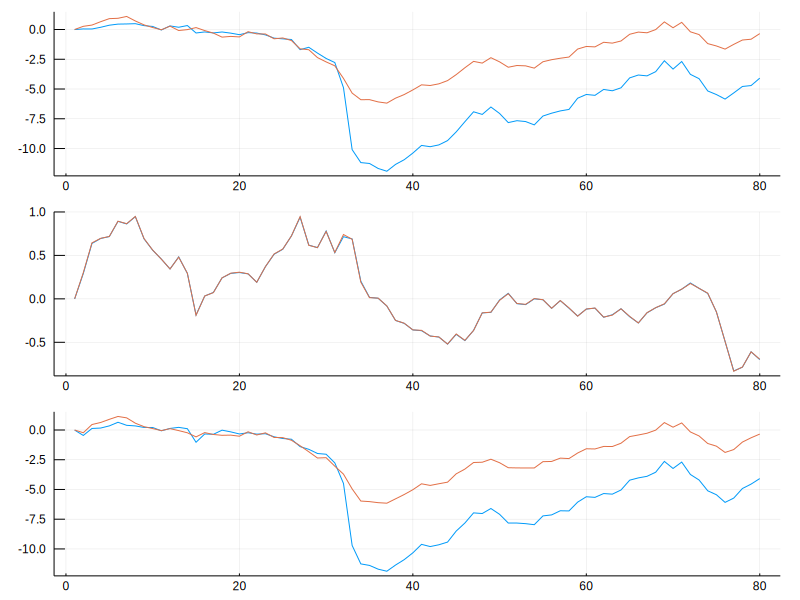

In [41]:
y1 = [mean(all_s_up[:,5,:],dims=2), statepredi[1:end-1,5]]
y2 = [mean(all_s_up[:,6,:],dims=2), statepredi[1:end-1,6]]
y3 = [mean(all_s_up[:,1,:],dims=2), statepredi[1:end-1,1]]
plot(
    plot([1:80],y1),
    plot([1:80],y2),
    plot([1:80],y3),
    layout=(3,1),size=(800,600),legend=false
)

40000


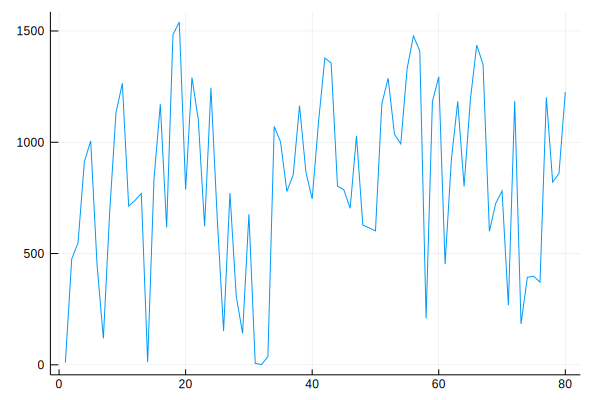

In [42]:
println(N)
plot(Neff,legend=false)

In [33]:
liki, measurepredi, statepredi, varstatepredi = KF(A,B,H,R,S2,Phi,yt)

N_opts = [50, 100, 10000]
# N_opts = [40000]

Nrep = 100

lik_store = zeros(Nrep, size(N_opts)[1])

for r = 1:Nrep
    
    for n = 1:size(N_opts)[1]
        
        N = N_opts[n]
        
        @time lik, all_s_up, Neff = PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, 1)
        
        lik_store[r,n] = sum(lik) - sum(liki)
        
    end
    
end

  0.001737 seconds (3.57 k allocations: 2.347 MiB)
  0.007157 seconds (4.50 k allocations: 4.654 MiB, 66.66% gc time)
  0.383686 seconds (133.09 k allocations: 438.029 MiB, 35.75% gc time)
  0.002407 seconds (3.51 k allocations: 2.346 MiB)
  0.008924 seconds (4.48 k allocations: 4.654 MiB)
  0.398532 seconds (134.02 k allocations: 438.043 MiB, 31.22% gc time)
  0.010770 seconds (3.48 k allocations: 2.346 MiB)
  0.003481 seconds (4.48 k allocations: 4.654 MiB)
  0.398347 seconds (133.58 k allocations: 438.037 MiB, 33.17% gc time)
  0.011140 seconds (3.50 k allocations: 2.346 MiB)
  0.004023 seconds (4.55 k allocations: 4.655 MiB)
  0.381593 seconds (133.93 k allocations: 438.042 MiB, 32.06% gc time)
  0.002798 seconds (3.55 k allocations: 2.347 MiB)
  0.012001 seconds (4.59 k allocations: 4.655 MiB)
  0.461260 seconds (134.55 k allocations: 438.051 MiB, 34.24% gc time)
  0.009986 seconds (3.54 k allocations: 2.346 MiB)
  0.002318 seconds (4.39 k allocations: 4.652 MiB)
  0.381621 second

  0.410830 seconds (133.62 k allocations: 438.037 MiB, 32.98% gc time)
  0.013664 seconds (3.49 k allocations: 2.346 MiB)
  0.002980 seconds (4.41 k allocations: 4.653 MiB)
  0.419053 seconds (133.50 k allocations: 438.035 MiB, 35.85% gc time)
  0.002394 seconds (3.63 k allocations: 2.348 MiB)
  0.006541 seconds (4.61 k allocations: 4.656 MiB)
  0.377570 seconds (133.56 k allocations: 438.036 MiB, 32.90% gc time)
  0.008192 seconds (3.48 k allocations: 2.346 MiB)
  0.002361 seconds (4.44 k allocations: 4.653 MiB)
  0.377917 seconds (132.05 k allocations: 438.013 MiB, 32.57% gc time)
  0.008938 seconds (3.59 k allocations: 2.347 MiB)
  0.002253 seconds (4.56 k allocations: 4.655 MiB)
  0.376172 seconds (133.84 k allocations: 438.041 MiB, 35.50% gc time)
  0.008358 seconds (3.58 k allocations: 2.347 MiB)
  0.002356 seconds (4.57 k allocations: 4.655 MiB)
  0.385002 seconds (133.70 k allocations: 438.038 MiB, 32.03% gc time)
  0.008108 seconds (3.52 k allocations: 2.346 MiB)
  0.007091 se

  0.389093 seconds (133.63 k allocations: 438.037 MiB, 34.61% gc time)
  0.002363 seconds (3.50 k allocations: 2.346 MiB)
  0.011506 seconds (4.51 k allocations: 4.654 MiB)
  0.511787 seconds (133.40 k allocations: 438.034 MiB, 36.16% gc time)
  0.011882 seconds (3.56 k allocations: 2.347 MiB)
  0.006827 seconds (4.51 k allocations: 4.654 MiB)
  0.627688 seconds (133.61 k allocations: 438.037 MiB, 32.13% gc time)
  0.008997 seconds (3.54 k allocations: 2.346 MiB)
  0.003702 seconds (4.40 k allocations: 4.652 MiB)
  0.577708 seconds (134.93 k allocations: 438.057 MiB, 32.60% gc time)
  0.005924 seconds (3.60 k allocations: 2.347 MiB)
  0.002686 seconds (4.49 k allocations: 4.654 MiB)
  0.558586 seconds (133.29 k allocations: 438.032 MiB, 36.04% gc time)


In [36]:
m = mean(lik_store,dims=1)
v = std(lik_store,dims=1)
for i = 1:3
    println([Nrep N_opts[i] m[i] v[i]])
end

[100.0 50.0 -221.94 46.9493]
[100.0 100.0 -130.353 36.7963]
[100.0 10000.0 -5.39446 4.80969]


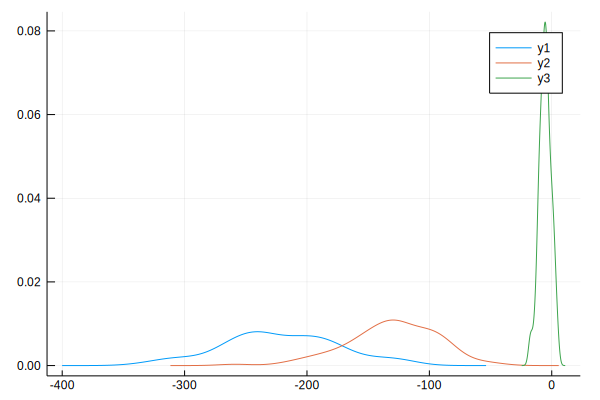

In [34]:
kd1 = kde(lik_store[:,1])
kd2 = kde(lik_store[:,2])
kd3 = kde(lik_store[:,3])

plot(kd1.x,kd1.density)
plot!(kd2.x,kd2.density)
plot!(kd3.x,kd3.density)